# Testing sim scripts.

In [ ]:
from shared.preface import *

box_name = 'L025N752'
box_ver = 'DMONLY/SigmaConstant00'
out_dir = f'{box_name}/{box_ver}'
nums_snaps = np.load(f'{out_dir}/nums_snaps.npy')
zeds = np.load(f'{out_dir}/zeds_snaps.npy')
zint = np.load(f'{out_dir}/z_int_steps.npy')
sint = np.load(f'{out_dir}/s_int_steps.npy')
print(nums_snaps)
print(zeds)
print(zint[:10])
print(sint[:10])

from shared.functions import read_DM_halo_index

with h5py.File(f'{out_dir}/MergerTree.hdf5') as tree:
    prog_IDs = tree['Assembly_history/Progenitor_index'][28,:]
    prog_IDs_np = np.array(np.expand_dims(prog_IDs, axis=1), dtype=int)

with open(f'{out_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)

box_file_dir = box_setup['File Paths']['Box File Directory']
print(box_file_dir, type(box_file_dir))
print(prog_IDs_np.flatten())

np.savetxt('prog_IDs.txt', prog_IDs_np.flatten(), fmt='%d')

In [1]:
!python simulation_analytical.py -d L025N752/DMONLY/SigmaConstant00 --MW_halo --no-VC_halo --no-AG_halo

From 1 to and incl. 10000
Batch 1/1 done!
Sim time: 0.15243199113344114 min, 0.0025405331855573522 h.


In [2]:
out_dir = f'L025N752/DMONLY/SigmaConstant00'
output = np.load(f'{out_dir}/neutrino_vectors_analytical_batch1.npy')
print(output.shape)

(10000, 100, 6)


In [7]:
!python simulation_numerical.py -d L025N752/DMONLY/SigmaConstant00 -st single_halos -mg 12.0 -mr 0.6 -hn 1

********Numerical Simulation: Mode=single_halos********
Halo batch params (Rvir,Mvir,cNFW):
[[253.5523526   12.24058042   6.9286026 ]]
***********************************
halo 1/1 ; snapshot 0012
halo 1/1 ; snapshot 0013
halo 1/1 ; snapshot 0014
halo 1/1 ; snapshot 0015
halo 1/1 ; snapshot 0016
halo 1/1 ; snapshot 0017
halo 1/1 ; snapshot 0018
halo 1/1 ; snapshot 0019
halo 1/1 ; snapshot 0020
halo 1/1 ; snapshot 0021
halo 1/1 ; snapshot 0022
halo 1/1 ; snapshot 0023
halo 1/1 ; snapshot 0024
halo 1/1 ; snapshot 0025
halo 1/1 ; snapshot 0026
halo 1/1 ; snapshot 0027
halo 1/1 ; snapshot 0028
halo 1/1 ; snapshot 0029
halo 1/1 ; snapshot 0030
halo 1/1 ; snapshot 0031
halo 1/1 ; snapshot 0032
halo 1/1 ; snapshot 0033
halo 1/1 ; snapshot 0034
halo 1/1 ; snapshot 0035
halo 1/1 ; snapshot 0036
***Running simulation: mode = single_halos***
halo=1/1, CPUs=128
Sim time: 2.197348520299905 min, 0.036622475338331746 h.
Total time: 35.39737151341663 min, 0.5899561918902771 h.


# Final Content of notebook.

## Load and transform simulation outputs.

In [ ]:
from shared.preface import *
import shared.functions as fct

def transform_simulation_outputs(box_name, box_ver, sim_fullname):
    """
    Input sim_fullname specifies the simulation mode with additional information: e.g. "single_halos_40k_test1" or "spheres_5shells_10k_final".
    """

    # Path to simulation outputs.

    # note: right now while testing, I didn't specify the sim_fullname...
    # out_dir = f'{box_name}/{box_ver}/{sim_fullname}'
    out_dir = f'{box_name}/{box_ver}'  # using this for now...


    # Try loading the equivalent output for the analytical simulation method.
    # If it hasn't been run yet, raise error and inform user.
    try:
        overdensities_analytical = np.load(
            f'{out_dir}/number_densities_analytical.npy'
        )/N0

        # Load neutrino vectors (positions and velocities) of the 10k batches, and concatenate them into a single array.
        neutrino_vectors_analytical = np.array([[[]]])  # empty (1,1,1) array

        batch_paths = glob.glob(
            f'{out_dir}/neutrino_vectors_numerical_batch*.npy'
        )
        for batch_path in batch_paths:
            batch_vectors = np.load(batch_path)
            neutrino_vectors_analytical = np.concatenate(
                (neutrino_vectors_analytical, batch_vectors), axis=0
            )

        analytical_out = True

        return overdensities_analytical, neutrino_vectors_analytical

    except FileNotFoundError:
        print('! Analytical simulation output not found !')
        analytical_out = False


    if 'single_halos' or 'spheres' in sim_fullname:
        # Load neutrino vectors (positions and velocities) of the 10k batches, and concatenate them into a single array.
        neutrino_vectors_numerical = np.array([[[]]])  # empty (1,1,1) array

        batch_paths = glob.glob(
            f'{out_dir}/neutrino_vectors_numerical_batch*.npy'
        )
        for batch_path in batch_paths:
            batch_vectors = np.load(batch_path)
            neutrino_vectors_numerical = np.concatenate(
                (neutrino_vectors_numerical, batch_vectors), axis=0
            )

        # Calculate overdensities.
        overdensities_numerical = np.load(f'{out_dir}/number_densities_numerical.npy')/N0

        if analytical_out:
            return overdensities_analytical, neutrino_vectors_analytical, overdensities_numerical, neutrino_vectors_numerical
        else:
            return overdensities_numerical, neutrino_vectors_numerical
    
    else:
        # Load angle pairs and calculate overdensities for the all_sky mode.
        all_sky_output = np.load(f'{out_dir}/number_densities_numerical.npy')
        angle_pairs = all_sky_output[:, :2]
        overdensities_numerical = all_sky_output[:, 2:]/N0

        return overdensities_numerical, angle_pairs


box_name = 'L025N752'
box_ver = 'DMONLY/SigmaConstant00'
sim_fullname = 'single_halos_10k'
etas, vectors = transform_simulation_outputs(box_name, box_ver, sim_fullname)

## Analyze and plot simulation outputs.

(100,) (100,)
(2, 100)


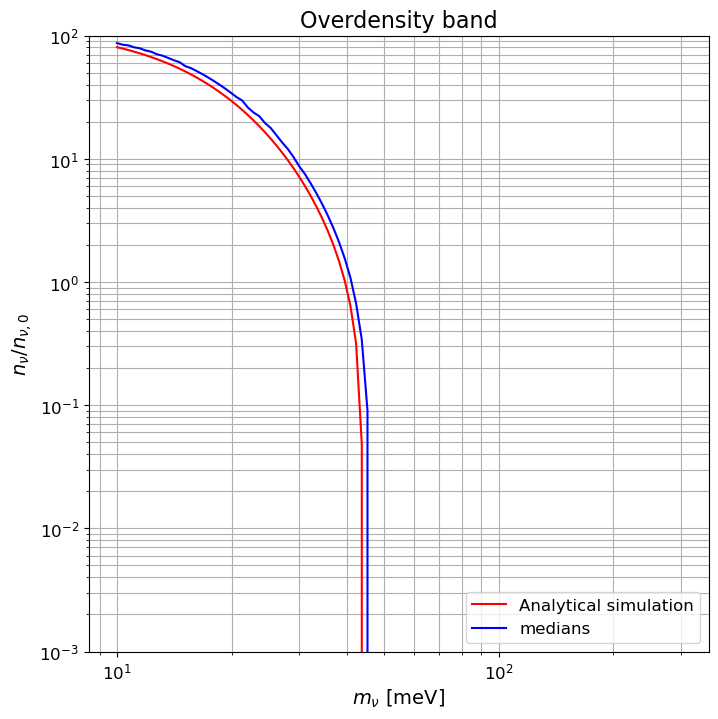

In [16]:
def analyze_simulation_outputs(
        etas, m_nu_range,
        box_name, box_ver,
        plots_to_make, ylims, Mertsch=False,
        # vectors, sim_fullname,
    ):

    # Figure directory.
    # fig_dir = f'figures/{box_name}/{box_ver}/{sim_fullname}'
    fig_dir = f'figures/{box_name}/{box_ver}'
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    savefig_args = dict(
        bbox_inches='tight'
    )

    if Mertsch:
        etas_analytical = etas[0,...]
        etas_numerical = etas[1,...]
    else:
        etas_numerical = etas[...]

    ### ================================== ###
    ### Figure of merit: overdensity band. ###
    ### ================================== ###

    fig, ax = plt.subplots(1,1)

    if 'overdensity_band' in plots_to_make:

        # Plot smooth simulation.
        ax.plot(
            m_nu_range*1e3, (etas_analytical-1), color='red', ls='solid', 
            label='Analytical simulation'
        )

        if etas_numerical.ndim <= 1:
            ax.plot(
                m_nu_range*1e3, (etas_numerical-1), color='blue', 
                label='medians'
            )
        else:
            nus_median = np.median(etas_numerical, axis=0)
            nus_perc2p5 = np.percentile(etas_numerical, q=2.5, axis=0)
            nus_perc97p5 = np.percentile(etas_numerical, q=97.5, axis=0)
            nus_perc16 = np.percentile(etas_numerical, q=16, axis=0)
            nus_perc84 = np.percentile(etas_numerical, q=84, axis=0)
            ax.plot(
                m_nu_range*1e3, (nus_median-1), color='blue', 
                label='Halo sample medians'
            )
            ax.fill_between(
                m_nu_range*1e3, (nus_perc2p5-1), (nus_perc97p5-1), 
                color='blue', alpha=0.2, label='2.5-97.5 %'
            )
            ax.fill_between(
                m_nu_range*1e3, (nus_perc16-1), (nus_perc84-1), 
                color='blue', alpha=0.3, label='16-84 %'
            )

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f'Overdensity band')
        ax.set_xlabel(r'$m_{\nu}$ [meV]')
        ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
        ax.set_ylim(ylims[0], ylims[1])
        plt.grid(True, which="both", ls="-")
        plt.legend(loc='lower right')


        plt.savefig(fig_dir, **savefig_args)
        plt.show()

    ### ================================== ###
    ### Figure of merit: overdensity band. ###
    ### ================================== ###



# Load analytical and numerical simulation output.
out_dir = f'L025N752/DMONLY/SigmaConstant00'
out_analytical = np.load(f'{out_dir}/number_densities_analytical.npy')
out_numerical = np.load(f'{out_dir}/number_densities_numerical.npy')
etas_combined = np.stack((out_analytical, out_numerical), axis=0)

print(out_analytical.shape, out_numerical.shape)
print(etas_combined.shape)

neutrino_massrange = np.load(f'{out_dir}/neutrino_massrange_eV.npy')*eV

analyze_simulation_outputs(
    etas=etas_combined, 
    m_nu_range=neutrino_massrange,
    box_name='L025N752', 
    box_ver='DMONLY/SigmaConstant00',
    plots_to_make=('overdensity_band', 'vels'), 
    ylims=(1e-3, 1e2),
    Mertsch=True
)